# EEMeter international

Two problems are encountered when running EEMeter on datasets outside of the US:

1. As it currently exists, EEMeter daily/billing does not account for unit conversion between Fahrenheit and Celsius.
2. Similarly, EEMeter hourly is currently written assuming default balance points for US buildings.

EEMeter international adds a regional toggle to overcome both these issues, referencing Celsius values outside of the US adding default balance point values for the United Kingdom, France, Germany, Spain and South Korea. This does not affect the operation of original EEMeter, with all _defaults_ set to the 'original' US settings.

These amendments were developed by Carbon Co-op and enabled by Innovate UK grant number 10032096 in 2022. Carbon Co-op is a membership-based energy services co-operative in Manchester, UK. Innovate UK is the UK's national innovation agency and an agency of the UK Government. As such, this notebook is drafted from the perspective of a UK user; however it is envisaged that these amendments are applicable to most regions affected by the above issues when running EEMeter outside of the US.

## Unit conversion

In order to construct a baseline model, EEMeter billing and daily models rely on the ability to choose one of four models: baseload-only, HDD* and CDD**, HDD-only, and CDD only. The latter two require electricity data, while the first two can operate with gas data only.

It is rare in the United Kingdom for residential dwellings to possess cooling systems, and most homes are currently heated by gas from the main network. Given the typical heating balance point for UK buildings lies at 15.5 degrees Celsius (Carbon Trust, 2012), it is to be expected that in the winter months the HDD model will be selected. However, since EEMeter daily/billing processes Fahrenheit data only, a 'baseload-only' model is returned. This issue is explained in eemeter issue no. 445 using sample data, and outlined in Figure 1 below.

HDD* = heating degree day

CDD** = cooling degree day

In [5]:
import eemeter

gas_us, temperature_data_us, metadata_us = eemeter.load_sample('il-gas-hdd-only-hourly', tempF=True)

In [7]:
gas_us

,value
start,
2015-11-22 06:00:00+00:00,0.06
2015-11-22 07:00:00+00:00,0.06
2015-11-22 08:00:00+00:00,0.12
2015-11-22 09:00:00+00:00,0.01
2015-11-22 10:00:00+00:00,0.09
...,...
2018-02-08 02:00:00+00:00,0.53
2018-02-08 03:00:00+00:00,0.02
2018-02-08 04:00:00+00:00,0.36


In [8]:
temperature_data_us

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
                             ...  
2018-02-08 02:00:00+00:00    17.06
2018-02-08 03:00:00+00:00    17.06
2018-02-08 04:00:00+00:00    17.05
2018-02-08 05:00:00+00:00    16.39
2018-02-08 06:00:00+00:00    15.99
Freq: H, Name: tempF, Length: 19417, dtype: float64

Running EEMeter daily for US data

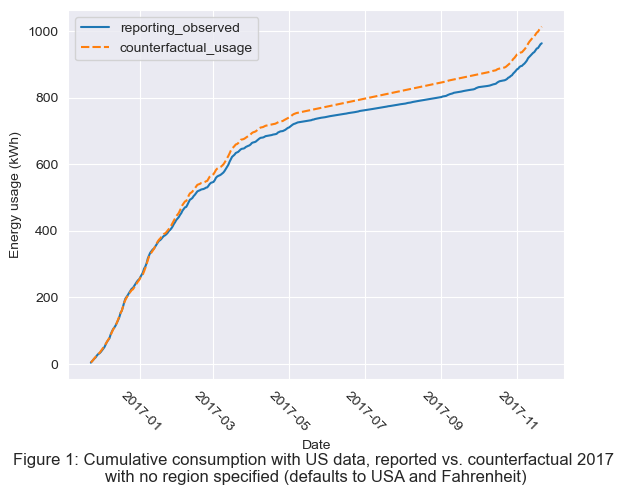

In [30]:
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
#running eemeter daily (see eemeter.openeneffs.processing)
gas_us = eemeter.format_energy_data_for_eemeter(gas_us, method='daily')

metered_savings_dataframe_us = eemeter.eemeter_daily(gas=gas_us, 
                                                  temperature_data = temperature_data_us, 
                                                  blackout_start_date = gas_us.index.min() + relativedelta(years=1), 
                                                  blackout_end_date = gas_us.index.min() + relativedelta(years=1), 
                                                  region='USA',
                                                  elec=None,
                                                 )

sns.set_style('darkgrid')
msd_cumsum_us = metered_savings_dataframe_us.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 1: Cumulative consumption with US data, reported vs. counterfactual 2017 \n'
'with no region specified (defaults to USA and Fahrenheit)', y=-.3)
plt.show()

Running EEMeter daily for UK data (with 'USA' specified as per original EEMeter)

In [21]:
gas_uk, temperature_data_uk, metadata_uk = eemeter.load_sample('uk-gas-hdd-only-hourly-sample-0', tempF=False)

gas_uk

,value
start,
2020-04-01 01:00:00+00:00,0.0000
2020-04-01 02:00:00+00:00,0.0000
2020-04-01 03:00:00+00:00,0.0000
2020-04-01 04:00:00+00:00,0.0224
2020-04-01 05:00:00+00:00,0.0449
...,...
2022-12-06 08:00:00+00:00,0.0000
2022-12-06 09:00:00+00:00,0.0000
2022-12-06 10:00:00+00:00,0.0000


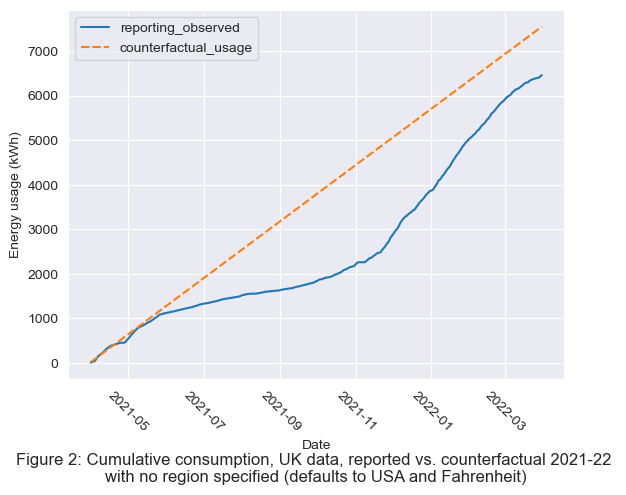

In [31]:
#note here the regional toggle is set to 'USA'. In this instance EEMeter is 'as is' without any conversion from Fahrenheit. 
#This means a set of HDD candidates are identified using a grid search of between 30C and 90C, 
#in which range is is extremely unlikely a heating balance point might lie.

gas_uk = eemeter.format_energy_data_for_eemeter(gas, method='daily')

metered_savings_dataframe_uk = eemeter.eemeter_daily(gas=gas_uk, 
                                                  temperature_data = temperature_data_uk, 
                                                  blackout_start_date = gas_uk.index.min() + relativedelta(years=1), 
                                                  blackout_end_date = gas_uk.index.min() + relativedelta(years=1), 
                                                  region='USA',
                                                  elec=None,
                                                 )

sns.set_style('darkgrid')
msd_cumsum_uk = metered_savings_dataframe_uk.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum_uk)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 2: Cumulative consumption, UK data, reported vs. counterfactual 2021-22 \n'
'with no region specified (defaults to USA and Fahrenheit)', y=-.3)
plt.show()

After specifying the correct region (...and amending the candidate balance point bins)

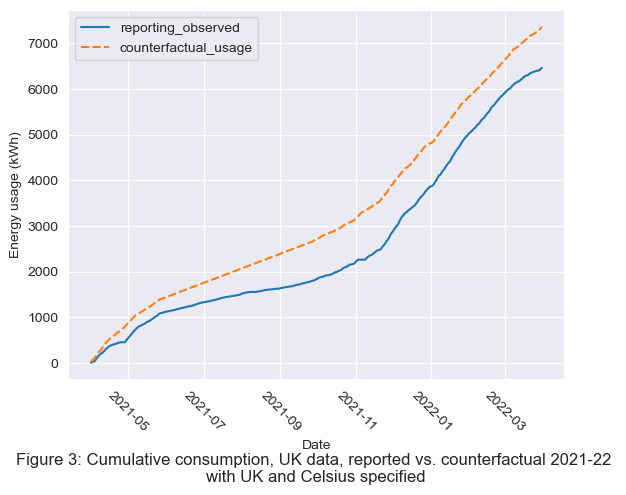

In [32]:
gas_uk = eemeter.format_energy_data_for_eemeter(gas, method='daily')

metered_savings_dataframe_uk = eemeter.eemeter_daily(gas=gas_uk, 
                                                  temperature_data = temperature_data_uk, 
                                                  blackout_start_date = gas_uk.index.min() + relativedelta(years=1), 
                                                  blackout_end_date = gas_uk.index.min() + relativedelta(years=1), 
                                                  region='UK',
                                                  elec=None,
                                                 )

sns.set_style('darkgrid')
msd_cumsum_uk = metered_savings_dataframe_uk.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum_uk)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 3: Cumulative consumption, UK data, reported vs. counterfactual 2021-22 \n'
'with UK and Celsius specified', y=-.3)
plt.show()

### How does this affect EEMeter? 

In [37]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

elec, temperature_data, metadata = eemeter.load_sample('uk-electricity-hdd-only-hourly-sample-1', tempF=False) #need to demonstrate how to load samples
gas=None
# convert from degC to degF
temperature_data_degF = 32 + (temperature_data * 1.8)

blackout_start_date = elec.dropna().index.min() + pd.Timedelta(days=365)
blackout_end_date = blackout_start_date

# Run two studies, one in the UK with degC and one in the US with degF
elec_daily = eemeter.format_energy_data_for_eemeter(elec, method='daily')
metered_savings_UK = eemeter.eemeter_daily(
    gas, elec_daily, temperature_data, blackout_start_date, blackout_end_date, region="UK"
)
metered_savings_US = eemeter.eemeter_daily(
    gas, elec_daily, temperature_data_degF, blackout_start_date, blackout_end_date, region="USA"
)

# Get the required data into a single DataFrame and then plot it
metered_savings = metered_savings_US[["reporting_observed", "counterfactual_usage"]]
metered_savings = metered_savings.rename(columns={"counterfactual_usage": "counterfactual_US"})
metered_savings["counterfactual_UK"] = metered_savings_UK["counterfactual_usage"]
metered_savings["US_UK_diff"] = metered_savings["counterfactual_US"] - metered_savings["counterfactual_UK"]

fig = px.scatter(metered_savings, y=["reporting_observed", "counterfactual_UK", "counterfactual_US"])
fig.show()
plt.clf()

# Find the abs sum of all the diffs
print(metered_savings["US_UK_diff"].abs().sum())      

0.5992775023415646


<Figure size 640x480 with 0 Axes>

In [38]:
# Run two studies, one in the UK with degC and one in the US with degF
metered_savings_UK = eemeter.eemeter_hourly(
gas, elec, temperature_data, blackout_start_date, blackout_end_date, region="UK"
)
metered_savings_US = eemeter.eemeter_hourly(
gas, elec, temperature_data_degF, blackout_start_date, blackout_end_date, region="USA"
)
# Get the required data into a single DataFrame and then plot it
metered_savings = metered_savings_US[["reporting_observed", "counterfactual_usage"]]
metered_savings = metered_savings.rename(columns={"counterfactual_usage": "counterfactual_US"})
metered_savings["counterfactual_UK"] = metered_savings_UK["counterfactual_usage"]
metered_savings["US_UK_diff"] = metered_savings["counterfactual_US"] - metered_savings["counterfactual_UK"]

fig = px.scatter(metered_savings, y=["reporting_observed", "counterfactual_UK", "counterfactual_US"])
fig.show()

# Find the abs sum of all the diffs
print(metered_savings["US_UK_diff"].abs().sum())

13.943241909304714
